---
## <font color="red">1 | CLASSIFICATEUR </font> POUR LE _DATASET_ FASHION-MNIST
---

Dans ce notebook, vous apprendrez à implémenter et à entraîner un réseau de neurones (NN) avec une couche cachée dans l'ensemble de données Fashion MNIST en Python, ce qui vous permettra de classer des images des vêtements.

### <font color="red">1.1 - Les</font> paquets
---
Importons d’abord tous les packages dont vous aurez besoin. Si dans votre environnement python il vous manque quelque paquet, vous pouvez l'installer avec la commande `pip intall <paquet>` :

* [mathplotlib](https://matplotlib.org/) : C'est une bibliothèque pour tracer des graphiques en Python.
* [numpy](https://numpy.org/) : Extension destinée à manipuler des matrices ou tableaux multidimensionnels ainsi que des fonctions mathématiques opérant sur ces tableaux.
* [idx2numpy](https://pypi.org/project/idx2numpy/) : Fournit les outils de conversion de fichiers du format IDX au format `numpy.ndarray` et vice versa.
* [tabulate](https://pypi.org/project/idx2numpy/) : Pour afficher des tableaux d'une manière facile à lire.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
import idx2numpy
from plot_fmnist import *

In [2]:
# Always run this cell to display the complete output in the cells, not just the last result.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### <font color="red">1.2 - L'ensemble</font> FASHION-MNIST
---
Fashion-MNIST est un ensemble de données d'images d'articles de [Zalando](https://jobs.zalando.com/tech/), consistant en un ensemble de formation de 60.000 exemples et un ensemble de test de 10.000 exemples. Chaque exemple est une image en niveaux de gris de 28x28 pixels, associée à une étiquette d'entre 10 classes.

Ce guide utilise Fashion-MNIST car il est un peu plus complexe que le MNIST (utilisé dans le notebook précédent). Les deux ensembles de données sont relativement petits et permettent de vérifier le bon fonctionnement d'un algorithme, dans ce cas, le réseau de neurones.

Nous utiliserons 60.000 images pour entraîner le réseau et 10.000 images pour évaluer dans quelle mesure le réseau a appris à classer les images.

Vous pouvez accéder à l'ensemble Fashion-MNIST directement sur le site Kagle ([fashion-mnist](https://www.kaggle.com/zalando-research/fashionmnist)) ou à partir de TensorFlow. Pour ce notebook, nous l'avons déjà disponible dans le dossier `data` :

In [3]:
# TRAINING DATASET
# Examples
X = idx2numpy.convert_from_file('data/train-images-idx3-ubyte')
# Labels
y = idx2numpy.convert_from_file('data/train-labels-idx1-ubyte')

# TEST DATASET
# Examples
X_test = idx2numpy.convert_from_file('data/t10k-images-idx3-ubyte')
# Labels
y_test = idx2numpy.convert_from_file('data/t10k-labels-idx1-ubyte')

* Les tableaux `X` et `y` sont les données que le modèle utilise pour apprendre pendant l'entraînement.

* Le modèle est testé sur les données de test, X_test et y_test.

Les images sont des tableaux NumPy 28x28, avec des valeurs de pixels allant de 0 à 255. Les étiquettes sont un tableau d’entiers allant de 0 à 9. Celles-ci correspondent à la classe de vêtement représentée par l’image. Chaque exemple d'entraînement et de test est attribué à l’une des étiquettes suivantes :


| Label | Class 
| ----- | -----
| 0 | T-shirt/top 
| 1 | Trouser 
| 2 | Pullover 
| 3 | Dress 
| 4 | Coat 
| 5 | Sandal 
| 6 | Shirt 
| 7 | Sneaker 
| 8 | Bag 
| 9 | Ankle boot

Chaque image est mappée sur une seule étiquette. Étant donné que les noms de classe ne sont pas inclus dans l'ensemble de données, stockez-les ici pour les utiliser ultérieurement lors du traçage des images:

Étant donné que les noms de classe ne sont pas inclus dans l'ensemble de données, nous allons créer une liste pour mapper cette table de correspondances entre le numéro d'étiquette et la classe, pour les utiliser ultérieurement lors du traçage des images :

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### <font color="red">1.3 - Exploration</font> des données
---
Explorons le format de l'ensemble de données avant d'entraîner le modèle. Les éléments suivants montrent que l'ensemble d’entraînement contient 60.000 images, chaque image étant représentée par 28 x 28 pixels:

In [5]:
# Training dataset dimensions
print("X: ", X.shape, "training examples")

# Test dataset dimensions
print("X_test: ", X_test.shape, "test examples")

X:  (60000, 28, 28) training examples
X_test:  (10000, 28, 28) test examples


In [6]:
print("y: ", y.shape, "training labels")
y

print("y_test: ", y_test.shape, "test labels")
y_test

y:  (60000,) training labels
y_test:  (10000,) test labels


array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)

Maintenant, créons une fonction pour tracer une image de l'ensemble :

In [7]:
def plot_product(xi, yi):
    # Transforms a given example i of 784 pixels into its original shape of 28x28
    img = xi.reshape(28,28)
    
    # cmap sets the color of a plot. Binary means black and white
    plt.imshow(img,  cmap=plt.cm.binary)
    
    # Using the mapping list between label number and name
    plt.title(f"True label: {class_names[yi]}")   
    
    plt.colorbar()
    plt.grid(False)
    plt.show()

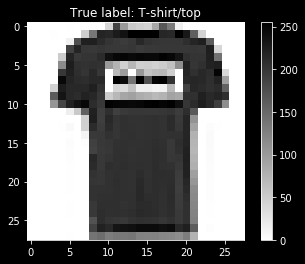

In [8]:
plot_product(X[1], y[1])

### <font color="red">1.4 - Prétraiter</font> les données
---
Les données doivent être prétraitées avant d'entraîner le réseau. Si vous inspectez la première image de l'ensemble d'apprentissage, vous verrez que les valeurs de pixel sont comprises entre 0 et 255 :

In [9]:
X[1]

array([[  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
         54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   1,   0,   0,   0,  49, 136, 219, 216, 228, 236,
        255, 255, 255, 255, 217, 215, 254, 231, 160,  45,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,  14, 176, 222, 224, 212, 203, 198, 196,
        200, 215, 204, 202, 201, 201, 201, 209, 218, 224, 164,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0, 188, 219, 200, 198, 202, 198, 199, 199,
        201, 196, 198, 198, 200, 200, 200, 200, 201, 200, 225,  41,   0,
          0,   0],
       [  0,   0,   0,   0,  51, 219, 199, 203, 203, 212, 238, 248, 250,
        245, 249, 246, 247, 252, 248, 235, 207, 203, 203, 222, 140,   0,
          0,   0],
       [  0,   0,   0,   0, 116, 226, 206, 204, 207, 204, 101,  75,  47,
         73,  48,  50,  45,  51,  63, 113, 222, 202, 206, 220, 224,   0,
          0,   0],
       [  

La plupart du temps, votre ensemble des données contiendra des primitives très variables en magnitudes (0-255, par exemple). 

Mais comme la plupart des algorithmes de ML utilisent la distance euclédienne entre deux points dans leurs calculs, cela pose un problème: 

Les primitives de grande magnitude pèseront beaucoup plus dans les calculs de distance que les primitives de faible magnitude.

Pour supprimer cet effet, nous devons amener toutes les fonctionnalités au même niveau de magnitude.

En utilisant le `MinMaxScaler` de sklearn, chaque pixel est transformé de valeurs entre 0 et 255 en valeurs entre 0 et 1 :

array([  0,   0,   0,   0,   0,   1,   0,   0,   0,   0,  41, 188, 103,
        54,  48,  43,  87, 168, 133,  16,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   1,   0,   0,   0,  49, 136, 219, 216,
       228, 236, 255, 255, 255, 255, 217, 215, 254, 231, 160,  45,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,  14, 176, 222, 224,
       212, 203, 198, 196, 200, 215, 204, 202, 201, 201, 201, 209, 218,
       224, 164,   0,   0,   0,   0,   0,   0,   0,   0,   0, 188, 219,
       200, 198, 202, 198, 199, 199, 201, 196, 198, 198, 200, 200, 200,
       200, 201, 200, 225,  41,   0,   0,   0,   0,   0,   0,   0,  51,
       219, 199, 203, 203, 212, 238, 248, 250, 245, 249, 246, 247, 252,
       248, 235, 207, 203, 203, 222, 140,   0,   0,   0,   0,   0,   0,
         0, 116, 226, 206, 204, 207, 204, 101,  75,  47,  73,  48,  50,
        45,  51,  63, 113, 222, 202, 206, 220, 224,   0,   0,   0,   0,
         0,   0,   0, 200, 222, 209, 203, 215, 200,   0,  70,  9

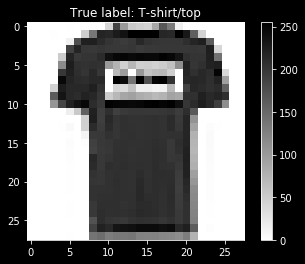

In [10]:
# Transforming each matrix example of 28x28 pixles in a vector example of 784 pixels
X = X.reshape(len(y), 784)
X_test = X_test.reshape(len(y_test), 784)

# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)
# X_test = scaler.fit_transform(X_test)

X[1]
plot_product(X[1], y[1])

Pour vérifier que les données sont au format correct et que vous êtes prêt à créer et à former le réseau, affichons les 25 premières images de l'ensemble d'apprentissage et affichons le nom de la classe sous chaque image.

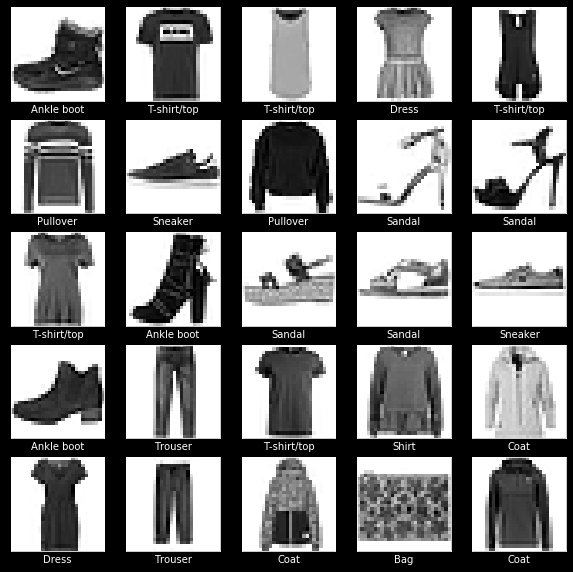

In [11]:
def plot_product_grid(X, y, rows, cols):
    plt.figure(figsize=(2*rows, 2*cols))  # set the size of the figure 10 inches by 10 inches
    for i in range(rows*cols):  # iterates over 25 images
        plt.subplot(rows, cols, i+1)  # indicate each cell in the plot
        plt.xticks([])  # void x axis ticks
        plt.yticks([])  # void y axis ticks
        plt.grid(False)
        plt.imshow(X[i].reshape(28,28), cmap=plt.cm.binary)  # set image to display in current cell
        plt.xlabel(class_names[y[i]])  # class to display in currente cell
    plt.show()

plot_product_grid(X[:25], y[:25], 5, 5)

### <font color="red">1.5 - Implémentation</font> du modèle
--- 
L'implémentation du modèle se fera à l'aide d'une classe appelée `NNClassifier`, avec les paramètres d'initialisation suivants:

```Python
class NNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=30, epochs=500, 
                 learning_rate=0.01, n_batches=1):
        
        # Parameters of the network
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units       
        self.n_batches = n_batches
        self.w1, self.w2 = self.weights()
        
        self.epochs = epochs
```

Après on va créer les matrices de poids aléatoires pour les valeurs initiaux :

```Python
class NNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=30, epochs=500, 
                 learning_rate=0.01, n_batches=1):
        
        # Parameters of the network
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units       
        self.n_batches = n_batches
        self.w1, self.w2 = self.weights()
        
        self.epochs = epochs
        self.learning_rate = learning_rate        

    def weights(self):
        # Weight matrix from input to hidden layer
        w1 = np.random.rand(self.n_hidden_units, self.n_features)        
        
        # Weight matrix from hidden to output layer
        w2 = np.random.rand(self.n_classes, self.n_hidden_units)        
        
        return w1, w2
```

### **Function sigmoïde**

L'une des raisons d'utiliser la fonction sigmoïde est due à ses propriétés mathématiques, dans notre cas, à ses dérivées. Lorsque le réseau de neurones fait le backpropagation pour apprendre et mettre à jour les poids, nous utiliserons sa dérivée. À continuation implémentez la fonction `sigmoide` et `sigmoide_prime`

\begin{equation}
    \sigma(x) = \frac{1}{1+\exp^{-x}} \\
    \sigma'(x) = \sigma(x) \cdot (1-\sigma(x))
\end{equation}


In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_prime(z):
    o = sigmoid(z)
    return o*(1-o)

### **Mesurer l'erreur**

La fonction de perte est un moyen de mesurer la performance de votre réseau par rapport aux valeurs réelles.

La fonction de perte la plus couramment utilisée est l'erreur quadratique moyenne. Comme nous traitons d'un problème de classification multi-classes, le résultat sera une distribution de probabilité. nous devons la comparer à nos valeurs réelles, qui sont aussi une distribution de probabilité, et trouver l'erreur.

Nous allons utiliser la fonction de Cross-Entropy pour évaluer l’erreur. Cette fonction mesure les performances d'un modèle de classification dont le résultat est une probabilité.


\begin{equation}
    Cross-Entropy = -\sum_{c=1}^{C} y_{o,c}\log(p_{o,c})
\end{equation}

Ou :

* $C$ : C'est le nombre de classes
* $y$ : C'est un indicateur binaire si l'étiquette de classe est la classification correcte pour l'observation
* $p$ : C'est la probabilité prédite que $o$ est de la classe $c$

À conitnuation, faites l'implémentation en python de cette fonction :

In [13]:
def cross_entropy(outputs, y_target):
    return -np.sum(y_target*np.log(outputs))
    

Maintenant que nous avons notre fonction de perte, nous pouvons enfin définir l'erreur pour notre modèle:

```Python
class NNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=30, epochs=500, 
                 learning_rate=0.01, n_batches=1):
        
        # Parameters of the network
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units       
        self.n_batches = n_batches
        self.w1, self.w2 = self.weights()
        
        self.epochs = epochs
        self.learning_rate = learning_rate        

    def weights(self):
        # Weight matrix from input to hidden layer
        w1 = np.random.rand(self.n_hidden_units, self.n_features)        
        
        # Weight matrix from hidden to output layer
        w2 = np.random.rand(self.n_classes, self.n_hidden_units)        
        
        return w1, w2
    
    def error(self, y, output):
        error = cross_entropy(output, y)
        return 0.5 * np.mean(error)
```

### **Propagation en avant**

Le processus de feed-forward est assez simple. La formule $z = (weights \cdot input)$ calcule $z$ qui est passé dans les couches, qui contient des fonctions d'activation spécifiques. Ces fonctions d'activation produisent la sortie $f(z)$. La sortie de la couche actuel sera l'entrée de la couche suivant et ainsi de suite.

À continuation, complétez la fonction `summation` d'accord à la formule précédente : 

In [14]:
def summation(w, X):
    return np.dot(w,X) #+ w[0]

Maintenant que l'on a les fonctions `sigmoid` et `summation`, on peut implémenter le `forward` :

```Python
class NNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=30, epochs=500, 
                 learning_rate=0.01, n_batches=1):
        
        # Parameters of the network
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units       
        self.n_batches = n_batches
        self.w1, self.w2 = self.weights()
        
        self.epochs = epochs
        self.learning_rate = learning_rate        

    def weights(self):
        # Weight matrix from input to hidden layer
        w1 = np.random.rand(self.n_hidden_units, self.n_features)        
        
        # Weight matrix from hidden to output layer
        w2 = np.random.rand(self.n_classes, self.n_hidden_units)        
        
        return w1, w2
    
    def error(self, y, output):
        error = cross_entropy(output, y)
        return 0.5 * np.mean(error)

    def forward(self, X):
        # dot product of X (input) and first set of weights
        z1 = summation(self.w1, X.T)  # self.w1.dot(X.T) 
        hidden_output = sigmoid(z1)  # activation function       
        
        
        # dot product of hidden layer and second set of weights
        z2 = summation(self.w2, hidden_output)  # self.w2.dot(hidden_output)
        final_output = sigmoid(z2)   # final activation function     
        
        return z1, hidden_output, z2, final_output
```

### **Propagation en arrière**

Fondamentalement, back-prop calcule l'erreur à partir de la sortie de feed-forward et de la valeur réelle. Cette erreur est rétro-propagée à toutes les matrices de pondération en calculant les gradients de chaque couche et ces pondérations sont mises à jour. Regardons donc les méthodes de `backward` et `train`:

Pour chaque époque, nous appliquons l'algorithme back-prop, évaluons l'erreur et le gradient par rapport aux poids. Nous utilisons ensuite le taux d’apprentissage et les gradients pour mettre à jour les poids.

Ensuite, nous devons utiliser un encodage one_hot, recherchez ce que c'est et pourquoi est-ce nécessaire :

In [15]:
def one_hot(y, n_labels):
    mat = np.zeros((len(y), n_labels))
    for i, val in enumerate(y):
        mat[i, val] = 1
    return mat

```Python
class NNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=30, epochs=500, learning_rate=0.01,
                 n_batches=1):
        # Parameters of the network
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.n_batches = n_batches
        self.w1, self.w2 = self.weights()

        self.epochs = epochs
        self.learning_rate = learning_rate

    def weights(self):
        # Weight matrix from input to hidden layer
        w1 = np.random.uniform(-1.0, 1.0,
                               size=(self.n_hidden_units, self.n_features))


        # Weight matrix from hidden to output layer
        w2 =   w2 = np.random.uniform(-1.0, 1.0,
                               size=(self.n_classes, self.n_hidden_units))

        return w1, w2

    def forward(self, X):
        # dot product of X (input) and first set of weights
        z1 = summation(self.w1, X.T)  # self.w1.dot(X.T)
        hidden_output = sigmoid(z1)  # activation function

        # dot product of hidden layer and second set of weights
        z2 = summation(self.w2, hidden_output)  # self.w2.dot(hidden_output)
        final_output = sigmoid(z2)   # final activation function

        return z1, hidden_output, z2, final_output
    
    def error(self, y, output):
        error = cross_entropy(output, y)
        return 0.5 * np.mean(error)

    def backward(self, X, z1, hidden_output, final_output, y):
        
        # Error in output
        output_error = final_output - y

        # Applying derivative of sigmoid to error
        output_delta = self.w2.T.dot(output_error) * sigmoid_prime(z1)

        # How much our input layer weights contributed to output error
        grad1 = output_delta.dot(X)

        # How much our hidden layer weights contributed to output error
        grad2 = output_error.dot(hidden_output.T)
        
        return grad1, grad2   

    def backprop_step(self, X, y):
        z1, hidden_output, z2, final_output = self.forward(X)
        y = y.T

        grad1, grad2 = self.backward(X, z1, hidden_output, final_output, y)
        
        # Calculating the error with the cross-entropy function
        error = self.error(y, final_output)

        return error, grad1, grad2   

    def train(self, X, y):
        self.error_ = []        
        y = one_hot(y, self.n_classes)
        
        # Divides the dataset in processing bathces
        X_bathces = np.array_split(X, self.n_batches)
        y_bathces = np.array_split(y, self.n_batches)      

        # Make the iterations
        for i in range(self.epochs):

            epoch_errors = []

            for Xi, yi in zip(X_bathces, y_bathces):

                # Update weights
                error, grad1, grad2 = self.backprop_step(Xi, yi)
                epoch_errors.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            self.error_.append(np.mean(epoch_errors))
        return self
```

### **Faire des prédictions**
Maintenant que notre modèle peut apprendre des données, il est temps de faire des prédictions sur des données qu'il n'a jamais vues auparavant. Nous allons implémenter deux méthodes de prédiction: `predict` et `predict_proba`.

```Python
def predict(self, X):          
        z1, hidden_output, z2, final_output = self.forward(X)
        return mle(z2.T)
```

Rappelez-vous que les prédictions dans un NN (généralement) incluent l’application d’un feed-forward sur les données. Mais il en résulte un vecteur de valeurs représentant le poids de chaque classe pour les données. Nous utiliserons l’estimation Maximum likelihood (MLE) pour obtenir nos prédictions finales. MLE fonctionne en choisissant la valeur la plus élevée et en la retournant sous forme de classe prédite pour l'entrée :

In [16]:
def mle(y, axis=1):
    return np.argmax(y, axis)

La méthode predict_proba retourne une distribution de probabilité sur toutes les classes, représentant la probabilité que chaque classe soit correcte. Notez que nous l'obtenons en appliquant la fonction `softmax` au résultat du pas en avant.

```Python
def predict_proba(self, X):        
    z1, hidden_output, z2, final_output = self.forward(X)
    return softmax(final_output.T)
```

La fonction `softmax` est une fonction d'activation qui transforme les nombres, c'est-à-dire les logits (sigmoïdes) en probabilités qui s'additionnent en un. La fonction `softmax` produit un vecteur qui représente les distributions de probabilité d'une liste de résultats potentiels.

\begin{equation}
    softmax(x_i) = \frac{exp^{x_j}}{\sum_{j} \exp^{x_i}} 
\end{equation}


In [17]:
def softmax(z):
    return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

In [18]:
class NNClassifier:

    def __init__(self, n_classes, n_features, n_hidden_units=30, epochs=500, learning_rate=0.01,
                 n_batches=1):
        # Parameters of the network
        self.n_classes = n_classes
        self.n_features = n_features
        self.n_hidden_units = n_hidden_units
        self.n_batches = n_batches
        self.w1, self.w2 = self.weights()

        self.epochs = epochs
        self.learning_rate = learning_rate

    def weights(self):
        # Weight matrix from input to hidden layer
        w1 = np.random.uniform(-1.0, 1.0,
                               size=(self.n_hidden_units, self.n_features))


        # Weight matrix from hidden to output layer
        w2 =   w2 = np.random.uniform(-1.0, 1.0,
                               size=(self.n_classes, self.n_hidden_units))

        return w1, w2

    def forward(self, X):
        # dot product of X (input) and first set of weights
        z1 = summation(self.w1, X.T)  # self.w1.dot(X.T)
        hidden_output = sigmoid(z1)  # activation function

        # dot product of hidden layer and second set of weights
        z2 = summation(self.w2, hidden_output)  # self.w2.dot(hidden_output)
        final_output = sigmoid(z2)   # final activation function
        
        # boucle for nombre de couche

        return z1, hidden_output, z2, final_output
    
    def error(self, y, output):
        error = cross_entropy(output, y)
        return 0.5 * np.mean(error)

    def backward(self, X, z1, hidden_output, final_output, y):
        
        # Error in output
        output_error = final_output - y

        # Applying derivative of sigmoid to error
        output_delta = self.w2.T.dot(output_error) * sigmoid_prime(z1)

        # How much our input layer weights contributed to output error
        grad1 = output_delta.dot(X)

        # How much our hidden layer weights contributed to output error
        grad2 = output_error.dot(hidden_output.T)
        
        return grad1, grad2   

    def backprop_step(self, X, y):
        z1, hidden_output, z2, final_output = self.forward(X)
        y = y.T

        grad1, grad2 = self.backward(X, z1, hidden_output, final_output, y)
        
        # Calculating the error with the cross-entropy function
        error = self.error(y, final_output)

        return error, grad1, grad2   

    def train(self, X, y):
        self.error_ = []        
        y = one_hot(y, self.n_classes)
        
        # Divides the dataset in processing bathces
        X_bathces = np.array_split(X, self.n_batches)
        y_bathces = np.array_split(y, self.n_batches)      

        # Make the iterations
        for i in range(self.epochs):

            epoch_errors = []

            for Xi, yi in zip(X_bathces, y_bathces):

                # Update weights
                error, grad1, grad2 = self.backprop_step(Xi, yi)
                epoch_errors.append(error)
                self.w1 -= (self.learning_rate * grad1)
                self.w2 -= (self.learning_rate * grad2)
            self.error_.append(np.mean(epoch_errors))
        return self
    
    def predict(self, X):        
        z1, hidden_output, z2, final_output = self.forward(X)
        return mle(z2.T)

    def predict_proba(self, X):        
        z1, hidden_output, z2, final_output = self.forward(X)
        return softmax(final_output.T)

    def score(self, X, y):
        y_hat = self.predict(X)
        return np.sum(y == y_hat, axis=0) / float(X.shape[0])

### **Évaluation**
La formation peut prendre un peu de temps, alors soyez patient.

In [19]:
N_FEATURES = 28 * 28 # 28x28 pixels for the images
N_CLASSES = 10

nn = NNClassifier(
    n_classes=N_CLASSES, 
    n_features=N_FEATURES,
    n_hidden_units=50,    # nombre de neurones dans la couche
    epochs=300,
    learning_rate=0.001,
    n_batches=25,
).train(X, y);

Jetons un coup d'oeil à l'erreur d'entraînement :

In [20]:
def plot_error(model):
    plt.plot(range(len(model.error_)), model.error_)
    plt.ylabel('Errors')
    plt.xlabel('Epochs')
    plt.show()

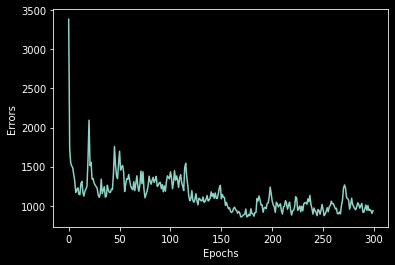

In [21]:
plot_error(nn)

Obtenons les prédictions :

In [22]:
y_hat = nn.predict_proba(X_test)

Jetons un coup d’œil à une seule prédiction :

<Figure size 432x216 with 0 Axes>

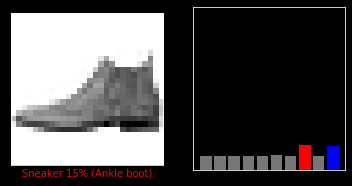

In [23]:
i = 0
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plot_image(i, y_hat, y_test, X_test)
plt.subplot(1, 2, 2)
plot_value_array(i, y_hat,  y_test)

Celui-là semble correct! Regardons quelques autres:

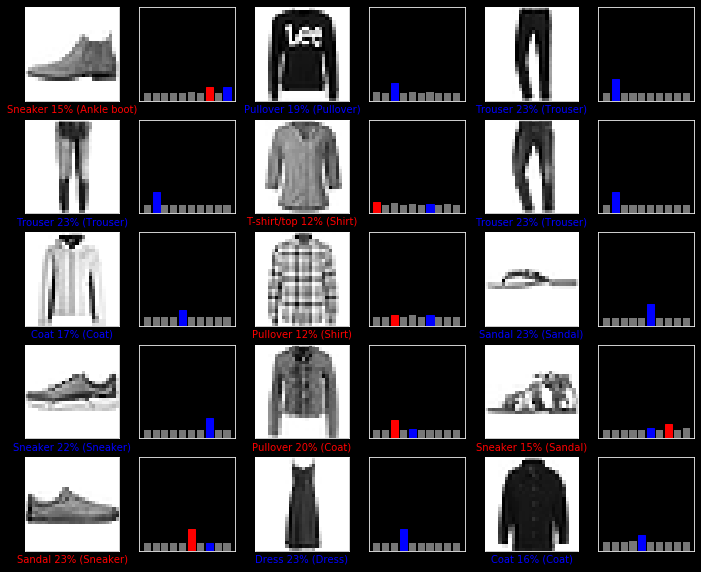

In [24]:
plot_image_grid(X_test, y_test, y_hat)

Précision de l'entraînement et des tests :

In [25]:
print('Train Accuracy: %.2f%%' % (nn.score(X, y) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test, y_test) * 100))

Train Accuracy: 75.35%
Test Accuracy: 74.72%


### <b>Questions finales</b>

1. À quoi sert la méthode one_hot ?
2. Que se passe-t-il si l'__image scaling_ n'est pas fait ? Effectuer un test pour le vérifier.
3. Effectuez des modifications aux valeurs des hyperparamètres pour tester le comportement du réseau.

1. One_hot est une manière d'encoder les données. C'est un processus par lequel des variables catégorielles sont converties en une forme qui peut être fournie à des algorithmes de machine learning pour faire un meilleur travail de prédiction. En effet, il faut adapter les données en les vectorisant avec une taille correspondant aux nombres de classes (nombre de neurones de sorties).

2. Ici, l'image scaling est très important. En effet, nous avons considéré chaque pixel comme étant une caractéristique. De cette manière, il faut redimensionner chaque image à la même dimension pour que chacune d'elle puisse être donnée en entrée du réseau.

In [48]:
import cv2
N_FEATURES = 28 * 28 # moins de features que de pixels
N_CLASSES = 10

# Image scaling in 14x14
X2 = []
for i in X:
    X2.append(cv2.resize(i, (14, 14)))

X2 = np.array(X2).reshape(len(y), 14*14)
print(X2.shape)

(60000, 196)


In [49]:
nn = NNClassifier(
    n_classes=N_CLASSES, 
    n_features=N_FEATURES,
    n_hidden_units=50,    # nombre de neurones dans la couche
    epochs=300,
    learning_rate=0.001,
    n_batches=25,
).train(X2[0:1000], y[0:1000])

ValueError: shapes (50,784) and (196,40) not aligned: 784 (dim 1) != 196 (dim 0)

Comme prévu, cela génère une erreur puisque le nombre de caractéristiques des données ne correspond pas à la taille de la couche d'entrée. Ce phénomène serait apparu même si l'une des images n'était pas de même dimension.

De plus, il peut aussi être intéressant de pouvoir modifier la taille des images pour prendre plus ou moins de features. De cette manière, on peut faire un compromis entre temps de prédiction et précision du modèle.

3. Le réseau de neurones a plusieurs hyperparamètres comme par exemples : le nombre de couches cachés, le nombre d'epochs, le taux d'apprentissage...  
On peut par exemple modifier le learning rate pour visualiser son effet. 

In [43]:
nn = NNClassifier(
    n_classes=N_CLASSES, 
    n_features=N_FEATURES,
    n_hidden_units=50,   
    epochs=300,
    learning_rate=0.1, # Grosse modification du learning rate
    n_batches=25,
).train(X[0:5000], y[0:5000])

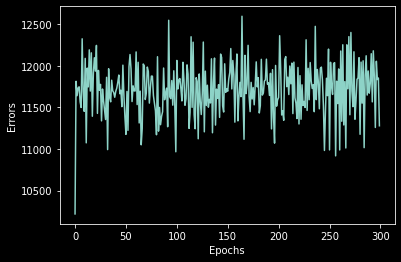

In [44]:
plot_error(nn)

In [45]:
print('Train Accuracy: %.2f%%' % (nn.score(X[:1000], y[:1000]) * 100))
print('Test Accuracy: %.2f%%' % (nn.score(X_test[:1000], y_test[:1000]) * 100))

Train Accuracy: 10.70%
Test Accuracy: 10.50%


On peut ainsi voir que la précision du modèle diminue beaucoup. On peut affiner le learning rate pour optimiser la précision. On pourrait également augmenter le nombre d'epochs, mais nous étudierons plus en détails dans le rapport de Labo.